In [20]:
import pandas as pd
from ipyleaflet import *
from branca.colormap import linear
import geopandas as gpd
import json
import pandas
from colour import Color
from pandas_profiling import ProfileReport
import numpy as np
from ipywidgets import *

ModuleNotFoundError: No module named 'ipyleaflet'

In [41]:
import seaborn as sns

In [13]:
pip install wbgapi

     |████████████████████████████████| 127 kB 1.4 MB/s eta 0:00:01
ERROR: selenium 4.0.0 has requirement urllib3[secure]~=1.26, but you'll have urllib3 1.25.11 which is incompatible.
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7
Note: you may need to restart the kernel to use updated packages.


# Récupération des données

In [7]:
# 1989-01-01 and 2020-12-31
df = pd.read_csv('/Users/mcolas/Documents/GitHub/UCDP-project/data_ucdp.csv')

/Users/mcolas/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Création d'une première base comportant des variables par pays et année que l'on utilisera dans la partie modélisation

#instabilité politique
df_insta_pol = pd.read_excel(r'C:\Users\matth\OneDrive - GENES\ENSAE 2A\Python pour le data scientist/p5v2018.xls')
df_insta_pol2 = df_insta_pol[df_insta_pol['year']>= 1989] #de 1989 à 2018
df_insta_pol3 = df_insta_pol2[['country','year','polity2']]


#vulnérabilité climatique
df_clim = pd.read_excel(r'C:\Users\matth\OneDrive - GENES\ENSAE 2A\Python pour le data scientist/donnees-indicateur-de-vulnerabilite-physique-au-changement-climatique (1).xlsx')
df_vul_chang_clim = df_clim[['Country', 'PVCCI']]
d = df_insta_pol3.merge(df_vul_chang_clim, left_on = 'country', right_on = 'Country').drop(columns = ['Country'])


#fractionalisation sociale
df_frac = pd.read_excel(r'C:\Users\matth\OneDrive - GENES\ENSAE 2A\Python pour le data scientist/indicateurs-de-fragmentation-ethnolinguistique.xls')
df_fractio_soci = df_frac[['country_name','fearon']]
d2 = d.merge(df_fractio_soci, left_on = 'country', right_on = 'country_name').drop(columns = ['country_name'])


#vulnérabilité économique structurelle
df1 = pd.read_excel(r'C:\Users\matth\OneDrive - GENES\ENSAE 2A\Python pour le data scientist/indicateur-de-vulnerabilite.xlsx')
df2 = df1[df1['year']>= 1989] #de 1989 à 2018
df_vul_eco = df2[['country','year','EVI']]


dataframe1 = d2.merge(df_vul_eco, left_on = 'country', right_on = 'country').drop(columns = ['year_x']).rename(columns = {'year_y': 'year'})



In [6]:
# Création d'une deuxième base comportant des variables par pays et année que l'on utilisera dans la partie modélisation

#Population totale, PIB par habitant (en $), Indice GINI, Indice de capital humain, Croissance annuelle du PIB
import wbgapi as wb
dataframe2 = wb.data.DataFrame(['SP.POP.TOTL','NY.GDP.PCAP.KD','NY.GDP.MKTP.KD.ZG','SI.POV.GINI','HD.HCI.OVRL'], labels =True, time = range(1989, 2020), columns = 'series').reset_index().rename(columns = {'Time': 'year', 'SP.POP.TOTL' : 'Population', 'NY.GDP.PCAP.KD' : 'PIB/hab', 'NY.GDP.MKTP.KD.ZG' : 'Croissance PIB', 'SI.POV.GINI' : 'GINI', 'HD.HCI.OVRL' : 'Capital Humain'}).drop(columns = ['time','economy'])


In [15]:
# On ne garde que les colonnes pour premièrement faire une carte de 
#la densité d'événements
# par pays au cours du temps
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Statistiques descriptives

In [24]:
df['best'].describe()

count    261864.000000
mean         10.275128
std         222.556417
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max       48183.000000
Name: best, dtype: float64

In [59]:
df_visu_conflit = df[['year','type_of_violence', 'conflict_new_id']].groupby(['year','type_of_violence']).nunique()
df_visu_conflit.columns = ['year1','type1','nombre_conflits']
df_visu_conflit = df_visu_conflit.drop(['year1','type1'], axis=1)
df_visu_conflit.head()

nombre_conflits
year type_of_violence                 
1989 1                              50
     2                              27
     3                              49
1990 1                              55
     2                              27

In [64]:
df_visu_conflit.index

MultiIndex([(1989, 1),
            (1989, 2),
            (1989, 3),
            (1990, 1),
            (1990, 2),
            (1990, 3),
            (1991, 1),
            (1991, 2),
            (1991, 3),
            (1992, 1),
            (1992, 2),
            (1992, 3),
            (1993, 1),
            (1993, 2),
            (1993, 3),
            (1994, 1),
            (1994, 2),
            (1994, 3),
            (1995, 1),
            (1995, 2),
            (1995, 3),
            (1996, 1),
            (1996, 2),
            (1996, 3),
            (1997, 1),
            (1997, 2),
            (1997, 3),
            (1998, 1),
            (1998, 2),
            (1998, 3),
            (1999, 1),
            (1999, 2),
            (1999, 3),
            (2000, 1),
            (2000, 2),
            (2000, 3),
            (2001, 1),
            (2001, 2),
            (2001, 3),
            (2002, 1),
            (2002, 2),
            (2002, 3),
            (2003, 1),
           

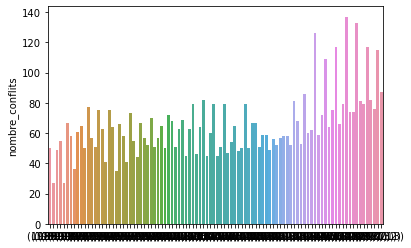

In [65]:
visu_conflit = sns.barplot(x= df_visu_conflit.index,y='nombre_conflits', data = df_visu_conflit)

# Exploration graphique

In [9]:
df_map = df[['id','year', 'where_coordinates', 'latitude', 'longitude', 'country','best','type_of_violence', 'side_a', 'side_b', 'source_headline']]
df_map

,id,year,where_coordinates,latitude,longitude,country,best,type_of_violence,side_a,side_b,source_headline
0,244657,2017,Kabul city,34.531094,69.162796,Afghanistan,6,1,Government of Iraq,IS,Attackers target Shiite mosque in Afghanistan'...
1,132140,1989,Nangarhar province,34.333330,70.416670,Afghanistan,6,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan,NaN
2,130364,1989,Kunduz province,36.750000,68.750000,Afghanistan,4,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan,NaN
3,130359,1989,Salang pass,35.315833,69.038889,Afghanistan,600,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan,NaN
4,133883,1989,Kabul city,34.531094,69.162796,Afghanistan,2,1,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan,NaN
...,...,...,...,...,...,...,...,...,...,...,...
261859,15525,1989,Chipinge district,-20.500000,32.500000,Zimbabwe (Rhodesia),9,3,Renamo,Civilians,NaN
261860,15524,1989,"Eastern Zimbabwe, near the Mozambique border",-19.000000,32.500000,Zimbabwe (Rhodesia),9,3,Renamo,Civilians,NaN
261861,15245,1990,Nyamaropa village,-18.000000,32.833333,Zimbabwe (Rhodesia),7,3,Renamo,Civilians,NaN
261862,15516,1990,"Eastern Zimbabwe, near the Mozambique border",-19.000000,32.500000,Zimbabwe (Rhodesia),1,3,Renamo,Civilians,NaN


In [10]:
ProfileReport(df_map, title="Données twitter").to_notebook_iframe()

NameError: name 'ProfileReport' is not defined

In [21]:
# Couleurs dans l'ordre croissant 0-10, 10-30, 30-50,50-100,100-400,400- 
def colors_count(count):
    
    colors = ['#f1c40f','#f39c12','#e67e22','#d35400','#e74c3c','#c0392b']
    if count < 11:
        return colors[0]
    elif count < 31:
        return colors[1]
    elif count < 51: 
        return colors[2]
    elif count < 101:
        return colors[3]
    elif count < 401:
        return colors[4]
    else:
        return colors[5]

def map_density(year=1989,type_event=0):

    densityMap = Map(basemap=basemaps.CartoDB.Positron,zoom=2, close_popup_on_click=False)
    
    if type_event == 0:
        data_year = df_map[df_map['year'] == year].country.value_counts()
    else:
        data_year = df_map[df_map['year'] == year][df_map['type_of_violence'] == type_event].country.value_counts()
    
    # On inclue une légende
    legend = LegendControl({'Entre 0 et 10 événements':'#f1c40f', 
                            'Entre 11 et 30 événements':'#f39c12', 
                            'Entre 31 et 50 événements':'#e67e22',
                           'Entre 51 et 100 événements' : '#d35400',
                           'Entre 101 et 400 événements' :'#e74c3c',
                           'Plus de 400 événements' :'#c0392b'}, name="Légende", position="bottomright")
    densityMap.add_control(legend)

    # On affiche la couleur adapté au nombre d'événement 
    for country,count in data_year.iteritems():
        geo_country = countries[countries["name"] == country]
        geodata = GeoData(geo_dataframe = geo_country, 
     style={"color": "black", "fillColor":colors_count(count), "opacity":0.03, "weight":1.9, "dashArray":"2", 
            "fillOpacity":0.6},name = "Countries")
        
        densityMap.add_layer(geodata)
    
    return densityMap

# Création des widgets pour rendre la carte interactive
interact(map_density,
         year=widgets.Dropdown(options=[i for i in range(1989,2021,1)], description='Année : '),
         type_event=widgets.Dropdown(options=[('Tous les événements', 0),
                                              ('Conflit impliquant au moins un état', 1), 
                                              ('Conflit entre des entités non-étatiques', 2), 
                                              ('Conflit visant des civils', 3)], description='Type :'))

interactive(children=(Dropdown(description='Année : ', options=(1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996…

<function __main__.map_density(year=1989, type_event=0)>

In [55]:
# Icone en forme d'éclair pour les conflits impliquant deux groupes
# Icone en forme de bombe pour les attaques visant les civils
icon = [AwesomeIcon(name='flash', icon_color='white'),
        AwesomeIcon(name='flash', icon_color='white'),
        AwesomeIcon(name='bomb', icon_color='white')]


# Couleurs dans l'ordre croissant
def colors_fatalities(fatalities):
    
    colors = ['green', 'orange','red','darkred','black']
    
    if fatalities == 0:
        return colors[0]
    elif fatalities < 11:
        return colors[1]
    elif fatalities < 41:
        return colors[2]
    elif fatalities < 101: 
        return colors[3]
    else:
        return colors[4]


    
def map_event(year=1,type_event=0,number_event=0.1,country='Tous'):

    clusterMap = Map(basemap=basemaps.CartoDB.Positron,zoom=2, close_popup_on_click=False)
    
    # On inclue une légende
    legend = LegendControl({'Aucun blessé':'green', 
                            'Entre 0 et 10 décés ':'orange', 
                            'Entre 11 et 40 décés':'red',
                           'Entre 41 et 100 décés' : 'darkred',
                           'Plus de 100 décés' :'black'}, name="Légende", position="bottomright")
    clusterMap.add_control(legend)
    
    # On stocke tous les marqueurs dans une liste
    markers_custom=[]
    
    # On sélectionne le pays si sélectionné
    if country != 'Tous':
        data_temp = df_map[df_map['year'] == year][df_map['country'] == country]
    else: 
        data_temp = df_map[df_map['year'] == year]
    
    if type_event == 0:
        data = data_temp.sample(frac=number_event)
    else:
        data = data_temp[df_map['type_of_violence'] == type_event].sample(frac=number_event)
    
    # On crée tous les marqueurs 
    for index,event in data.iterrows():

        # Création du message qui s'affiche en cliquant sur l'icone
        message = HTML()
        message.value = "<b>Localisation :</b> " + str(event.where_coordinates) + "<br /> <b>Nombre de morts :</b> " + str(event.best)
        if event.type_of_violence == 3:
            message.value += "<br /> <b> Attaque effectuée par : </b>" + event.side_a
            current_icon = AwesomeIcon(name='bomb', marker_color=colors_fatalities(event.best))
        else:
            message.value += "<br /> <b> Entité impliquée : </b>" + event.side_a + " / " + event.side_b
            current_icon = AwesomeIcon(name='flash', marker_color=colors_fatalities(event.best))
        
        
        # Création du marqueur au bon endroit avec la bonne icone
        marker = Marker(location=(event.latitude,event.longitude), draggable=False, icon=current_icon)

        
        marker.popup = message
    
        markers_custom.append(marker)
    
    # On affiche tous les événements sous forme de cluster
    clusterMap.add_layer(MarkerCluster(markers=markers_custom))
    
    return clusterMap

# Création des widgets pour rendre la carte interactive
interact(map_event,
         year=widgets.Dropdown(options=[i for i in range(1989,2021,1)], description='Année : '),
         type_event=widgets.Dropdown(options=[('Tous les événements', 0),
                                              ('Conflit impliquant au moins un état', 1), 
                                              ('Conflit entre des entités non-étatiques', 2), 
                                              ('Conflit visant des civils', 3)], description='Type :'),
         number_event=widgets.Dropdown(options=[('10% des événements de l\'année', 0.1),
                                                ('30% des événements de l\'année', 0.3), 
                                                ('50% des événements de l\'année (possiblement long)', 0.5), 
                                                ('80% des événements de l\'année (possiblement long)', 0.8),
                                               ('100% des événements de l\'année (possiblement long)', 1)], description='Afficher : '),
         country=widgets.Dropdown(options=['Tous'] + [name for name in countries.name.values], description='Pays : '))

interactive(children=(Dropdown(description='Année : ', options=(1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996…

<function __main__.map_event(year=1, type_event=0, number_event=0.1, country='Tous')>

In [27]:
data_year = df_map[df_map['year'] == 2015].best.value_counts()
data_year.mean()

120.39240506329114

In [31]:
colors_fatalities(1000)

'darkred'